In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from pprint import pprint
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Reduces tensorflow messages.
import data
import models

GLOBAL VARIABLES

In [2]:
UNITS = 100
OUTPUT_SIZE = 28

In [3]:
EPOCHS = 300
VERBOSE = 1
EVAL_VERBOSE = 0

In [4]:
LSTM_ACTIVATION = "tanh"

In [5]:
CHECKPOINT_PATHS = {"mol": "checkpoints/mol.ckpt",
                    "mog": "checkpoints/mog.ckpt",
                    "molv2": "checkpoints/molv2.ckpt",
                    "mogv2": "checkpoints/mogv2.ckpt",
                    "sol": "checkpoints/sol.ckpt",
                    "sog": "checkpoints/sog.ckpt",
                    "mlq": "checkpoints/mlq.ckpt",
                    "mgq": "checkpoints/mgq.ckpt",
                    "slq": "checkpoints/slq.ckpt",
                    "sgq": "checkpoints/sgq.ckpt"}

In [6]:
EXAMPLE_COUTRIES = ["United Kingdom", "Germany", "France", "Spain", "Italy"]

Get command line options

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument("--load_all", action="store_true", help="Load saved models.")
args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--load_all]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/marcus/.local/share/jupyter/runtime/kernel-030f04da-a45e-45f1-adef-a68a2b784ea7.json


SystemExit: 2

/home/marcus/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Load data

In [8]:
COVID_DATA = data.Data()

In [9]:
COVID_DATA.split_train_test(OUTPUT_SIZE)

In [10]:
COVID_DATA.standarize_data()

In [11]:
enc_names = COVID_DATA.encode_names()

In [12]:
train_x, train_y, test_x, test_y = COVID_DATA.retreive_data()

In [13]:
multi_train_y = COVID_DATA.make_multi_output_data(train_y)
multi_test_y = COVID_DATA.make_multi_output_data(test_y)

In [14]:
print("Data shapes")
print(f"enc_names: {enc_names.shape}")
print(f"train_x: {train_x.shape}, train_y: {train_y.shape}, test_x {test_x.shape}, test_y {test_y.shape}")
print(f"multi_train_y: {multi_train_y.shape}")
print(f"multi_test_y: {multi_test_y.shape}")

Data shapes
enc_names: (187,)
train_x: (187, 192, 3), train_y: (187, 28, 3), test_x (187, 192, 3), test_y (187, 28, 3)
multi_train_y: (3, 187, 28)
multi_test_y: (3, 187, 28)


In [15]:
Y_MULTI = {"confirmed_q1": multi_train_y[0],
           "confirmed_q2": multi_train_y[0],
           "confirmed_q3": multi_train_y[0],
           "deceased_q1": multi_train_y[1],
           "deceased_q2": multi_train_y[1],
           "deceased_q3": multi_train_y[1],
           "recovered_q1": multi_train_y[2],
           "recovered_q2": multi_train_y[2],
           "recovered_q3": multi_train_y[2]}

In [16]:
Y_SINGLE = {"output_q1": train_y,
            "output_q2": train_y,
            "output_q3": train_y}

These variables define the size of the time series and word encoding used for the input.

In [17]:
TEMPORAL_SHAPE = train_x[0].shape

Build models

In [18]:
print("Creating models...")
# Multi output individual weights.
multi_out_lstm = models.LSTMMultiOutput(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE, LSTM_ACTIVATION)
multi_out_gru = models.GRUMultiOutput(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE)

Creating models...


Multi output shared weights.

In [19]:
multi_out_lstm_V2 = models.LSTMMultiOutput_V2(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE, LSTM_ACTIVATION)
multi_out_gru_V2 = models.GRUMultiOutput_V2(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE)

Single output shared weights.

In [20]:
single_out_lstm = models.LSTMSingleOutput(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE, LSTM_ACTIVATION)
single_out_gru = models.GRUSingleOutput(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE)

Multi output quantile forecasts.

In [21]:
multi_lstm_quant = models.LSTMMultiOutputQuantile(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE, LSTM_ACTIVATION)
multi_gru_quant = models.GRUMultiOutputQuantile(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE)

Single output quantile forecasts.

In [22]:
single_lstm_quant = models.LSTMSingleOutputQuantile(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE, LSTM_ACTIVATION)
single_gru_quant = models.GRUSingleOutputQuantile(TEMPORAL_SHAPE, UNITS, OUTPUT_SIZE)

Load saved models instead of training them.

In [24]:
if True:
    print("Loading models...")
    multi_out_lstm.load_weights(CHECKPOINT_PATHS["mol"])
    multi_out_gru.load_weights(CHECKPOINT_PATHS["mog"])
    multi_out_lstm_V2.load_weights(CHECKPOINT_PATHS["molv2"])
    multi_out_gru_V2.load_weights(CHECKPOINT_PATHS["mogv2"])
    single_out_lstm.load_weights(CHECKPOINT_PATHS["sol"])
    single_out_gru.load_weights(CHECKPOINT_PATHS["sog"])
    multi_lstm_quant.load_weights(CHECKPOINT_PATHS["mlq"])
    multi_gru_quant.load_weights(CHECKPOINT_PATHS["mgq"])
    single_lstm_quant.load_weights(CHECKPOINT_PATHS["slq"])
    single_gru_quant.load_weights(CHECKPOINT_PATHS["sgq"])
    print("Done.")
else:
    print("Training models...")
    # Checkpoint callback
    mol_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["mol"], save_weights_only=True)
    mog_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["mog"], save_weights_only=True)
    molv2_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["molv2"], save_weights_only=True)
    mogv2_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["mogv2"], save_weights_only=True)
    sol_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["sol"], save_weights_only=True)
    sog_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["sog"], save_weights_only=True)
    mlq_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["mlq"], save_weights_only=True)
    mgq_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["mgq"], save_weights_only=True)
    slq_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["slq"], save_weights_only=True)
    sgq_cp = ModelCheckpoint(filepath=CHECKPOINT_PATHS["sgq"], save_weights_only=True)

    # Train models
    multi_out_lstm_hist = multi_out_lstm.fit([train_x, enc_names], [multi_train_y[0], multi_train_y[1], multi_train_y[2]],
                                             epochs=EPOCHS, verbose=VERBOSE, callbacks=[mol_cp])
    multi_out_gru_hist = multi_out_gru.fit([train_x, enc_names], [multi_train_y[0], multi_train_y[1], multi_train_y[2]],
                                           epochs=EPOCHS, verbose=VERBOSE, callbacks=[mog_cp])
    multi_out_lstm_V2_hist = multi_out_lstm_V2.fit([train_x, enc_names], [multi_train_y[0], multi_train_y[1], multi_train_y[2]],
                                                   epochs=EPOCHS, verbose=VERBOSE, callbacks=[molv2_cp])
    multi_out_gru_V2_hist = multi_out_gru_V2.fit([train_x, enc_names], [multi_train_y[0], multi_train_y[1], multi_train_y[2]],
                                                 epochs=EPOCHS, verbose=VERBOSE, callbacks=[mogv2_cp])
    single_out_lstm_hist = single_out_lstm.fit([train_x, enc_names], train_y, epochs=EPOCHS, verbose=VERBOSE, callbacks=[sol_cp])
    single_out_gru_hist = single_out_gru.fit([train_x, enc_names], train_y, epochs=EPOCHS, verbose=VERBOSE, callbacks=[sog_cp])
    multi_lstm_hist = multi_lstm_quant.fit([train_x, enc_names], y=Y_MULTI, epochs=EPOCHS, verbose=VERBOSE, callbacks=[mlq_cp])
    multi_gru_hist = multi_gru_quant.fit([train_x, enc_names], y=Y_MULTI, epochs=EPOCHS, verbose=VERBOSE, callbacks=[mgq_cp])
    single_lstm_hist = single_lstm_quant.fit([train_x, enc_names], y=Y_SINGLE, epochs=EPOCHS, verbose=VERBOSE, callbacks=[slq_cp])
    single_gru_hist = single_gru_quant.fit([train_x, enc_names], y=Y_SINGLE, epochs=EPOCHS, verbose=VERBOSE, callbacks=[sgq_cp])
    print("Done.")

Loading models...
Done.


Evaluate

In [25]:
print("Evaluating models...")
multi_out_lstm_eval = multi_out_lstm.evaluate([test_x, enc_names], [multi_test_y[0], multi_test_y[1], multi_test_y[2]],
                                              verbose=EVAL_VERBOSE, return_dict=True)

Evaluating models...


In [26]:
multi_out_gru_eval = multi_out_gru.evaluate([test_x, enc_names], [multi_test_y[0], multi_test_y[1], multi_test_y[2]],
                                            verbose=EVAL_VERBOSE, return_dict=True)

In [27]:
multi_out_lstm_V2_eval = multi_out_lstm_V2.evaluate([test_x, enc_names], [multi_test_y[0], multi_test_y[1], multi_test_y[2]],
                                                    verbose=EVAL_VERBOSE, return_dict=True)

In [28]:
multi_out_gru_V2_eval = multi_out_gru_V2.evaluate([test_x, enc_names], [multi_test_y[0], multi_test_y[1], multi_test_y[2]],
                                                  verbose=EVAL_VERBOSE, return_dict=True)

In [29]:
single_out_lstm_eval = single_out_lstm.evaluate([test_x, enc_names], test_y, verbose=EVAL_VERBOSE, return_dict=True)

In [30]:
single_out_gru_eval = single_out_gru.evaluate([test_x, enc_names], test_y, verbose=EVAL_VERBOSE, return_dict=True)

In [31]:
multi_lstm_eval = multi_lstm_quant.evaluate([test_x, enc_names], [multi_train_y[0], multi_train_y[0], multi_train_y[0],
                                                                  multi_train_y[1], multi_train_y[1], multi_train_y[1],
                                                                  multi_train_y[2], multi_train_y[2], multi_train_y[2]],
                                            verbose=EVAL_VERBOSE, return_dict=True)

In [32]:
multi_gru_eval = multi_gru_quant.evaluate([test_x, enc_names], [multi_train_y[0], multi_train_y[0], multi_train_y[0],
                                                                multi_train_y[1], multi_train_y[1], multi_train_y[1],
                                                                multi_train_y[2], multi_train_y[2], multi_train_y[2]],
                                          verbose=EVAL_VERBOSE, return_dict=True)

In [33]:
single_lstm_eval = single_lstm_quant.evaluate([test_x, enc_names], [test_y, test_y, test_y], verbose=EVAL_VERBOSE,
                                              return_dict=True)

In [34]:
single_gru_eval = single_gru_quant.evaluate([test_x, enc_names], [test_y, test_y, test_y], verbose=EVAL_VERBOSE, return_dict=True)
print("Done.")

Done.


Print results from evaluatin the models.

In [35]:
print("multi_out_lstm_eval")
pprint(multi_out_lstm_eval)
print()
print("multi_out_gru_eval")
pprint(multi_out_gru_eval)
print()
print("multi_out_lstm_V2_eval")
pprint(multi_out_lstm_V2_eval)
print()
print("multi_out_gru_V2_eval")
pprint(multi_out_gru_V2_eval)
print()
print("single_out_lstm_eval")
pprint(single_out_lstm_eval)
print()
print("single_out_gru_eval")
pprint(single_out_gru_eval)
print()
print("multi_lstm_eval")
pprint(multi_lstm_eval)
print()
print("multi_gru_eval")
pprint(multi_gru_eval)
print()
print("single_lstm_eval")
pprint(single_lstm_eval)
print()
print("single_gru_eval")
pprint(single_gru_eval)

multi_out_lstm_eval
{'confirmed_loss': 61.21330261230469,
 'confirmed_mean_squared_error': 61.21329879760742,
 'confirmed_root_mean_squared_error': 7.823893070220947,
 'deceased_loss': 68.58807373046875,
 'deceased_mean_squared_error': 68.58807373046875,
 'deceased_root_mean_squared_error': 8.281791687011719,
 'loss': 182.27293395996094,
 'recovered_loss': 52.471553802490234,
 'recovered_mean_squared_error': 52.471553802490234,
 'recovered_root_mean_squared_error': 7.243725299835205}

multi_out_gru_eval
{'confirmed_loss': 5.187435626983643,
 'confirmed_mean_squared_error': 5.187435626983643,
 'confirmed_root_mean_squared_error': 2.2775943279266357,
 'deceased_loss': 8.197134017944336,
 'deceased_mean_squared_error': 8.197134017944336,
 'deceased_root_mean_squared_error': 2.8630638122558594,
 'loss': 20.53722381591797,
 'recovered_loss': 7.152652740478516,
 'recovered_mean_squared_error': 7.152652740478516,
 'recovered_root_mean_squared_error': 2.6744444370269775}

multi_out_lstm_V2_eva

Predictions using best model on a selection of countries... (repeat for quantiles)

In [36]:
mulit_out_pred = multi_out_gru.predict([test_x, enc_names])
mulit_out_pred = np.stack(mulit_out_pred)

Reshape the predictions to fit the rescaler.

In [37]:
predictions = []
for c, d, r in zip(mulit_out_pred[0], mulit_out_pred[1], mulit_out_pred[2]):
    predictions.append(np.stack([c, d, r]).T)

In [38]:
predictions = np.stack(predictions)

De-standarize predictions and data...

In [39]:
rescaled_predictions = COVID_DATA.destandarize_data(predictions)

Plot predictions vs data...

In [40]:
def prepare_country_data_for_plots(name, enc_names, prediction_data):
    country = COVID_DATA.find_country(name)
    country_idx = (enc_names == country.encoded_name).nonzero()
    country_predictions = prediction_data[country_idx]
    country_predictions = country_predictions.reshape(country_predictions.shape[1], country_predictions.shape[2]).T
    return country_predictions, country.test_y.T

In [41]:
def plot_pred_v_data(pred, data, country_name):
    sub_titles = ["Confirmed", "Deceased", "Recovered"]
    fig, axes = plt.subplots(1, 3, constrained_layout=True)
    fig.suptitle(country_name)
    for idx, ax in enumerate(axes):
        ax.plot(pred[idx])
        ax.plot(data[idx])
        ax.set_title(sub_titles[idx])
        ax.set_xlabel("Days")
        ax.set_ylabel("People")
        ax.legend(["Model predictions", "Real data"], loc="best")

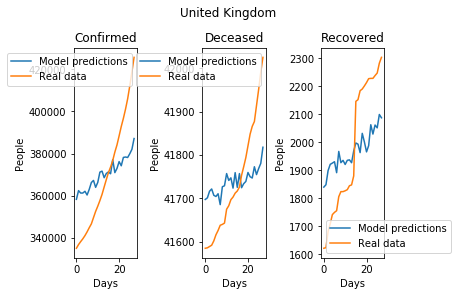

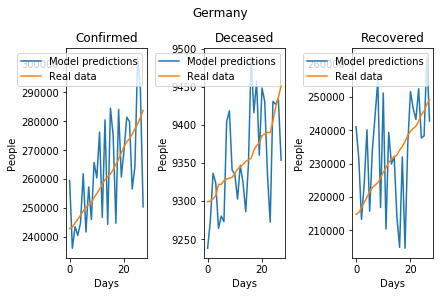

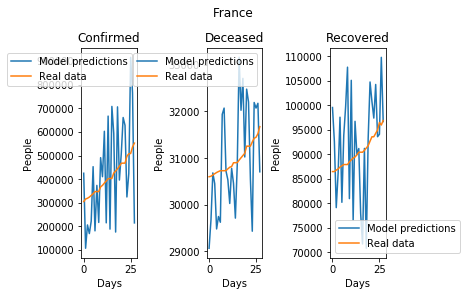

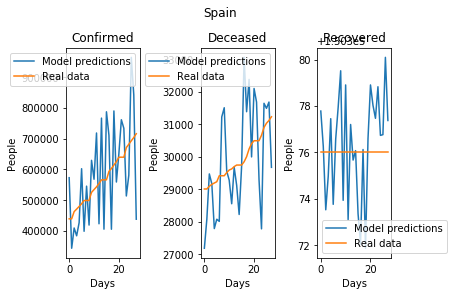

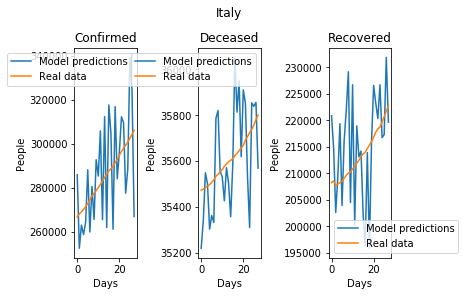

In [42]:
for country_name in EXAMPLE_COUTRIES:
    predictions, test_y = prepare_country_data_for_plots(country_name, enc_names, rescaled_predictions)
    plot_pred_v_data(predictions, test_y, country_name)

In [43]:
plt.show()